![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Compute precipitation and evapotranspiration rates for the relevant basins

In [1]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from common.config import read_config

In [2]:
conf=read_config()
datadir=conf["dataroot"]

In [3]:
basinsgpkg=os.path.join(datadir,'hydroshed_csl03_gl_l021.gpkg')
gdfbasins=gpd.read_file(basinsgpkg)
gdfbasins.head()

,PFAF_ID,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,ENDO,COAST,ORDER,SORT,name,geometry
0,111,1030000010,0,1030000010,1030000010,0.0,0.0,236343.2,236343.2,0,1,0,1,SETIT,"MULTIPOLYGON (((39.76528 15.42917, 39.75492 15..."
1,112,1030003990,0,1030003990,1030003990,0.0,0.0,519027.5,519027.5,0,1,0,2,GULF OF ADEN/SOMALIA,"MULTIPOLYGON (((40.81528 14.75417, 40.79561 14..."
2,114,1030008100,0,1030008100,1030008100,0.0,0.0,797881.4,797881.4,0,0,1,3,SHEBELLE,"MULTIPOLYGON (((36.74167 4.06667, 36.74131 4.0..."
3,117,1030008110,0,1030008110,1030008110,0.0,0.0,1040194.7,1040194.7,0,1,0,4,RUFIJI,"MULTIPOLYGON (((40.84444 -2.43333, 40.83833 -2..."
4,122,1030011660,0,1030011660,1030011660,0.0,0.0,1378103.3,1378121.1,0,0,1,6,ZAMBEZI,"MULTIPOLYGON (((35.2625 -18.23333, 35.26215 -1..."


In [4]:
p_et=os.path.join(datadir,'p-et.nc')
ds=xr.open_dataset(p_et)
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB ...
Data variables:
    avg_ie      (valid_time, latitude, longitude) float32 1GB ...
    avg_tprate  (valid_time, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

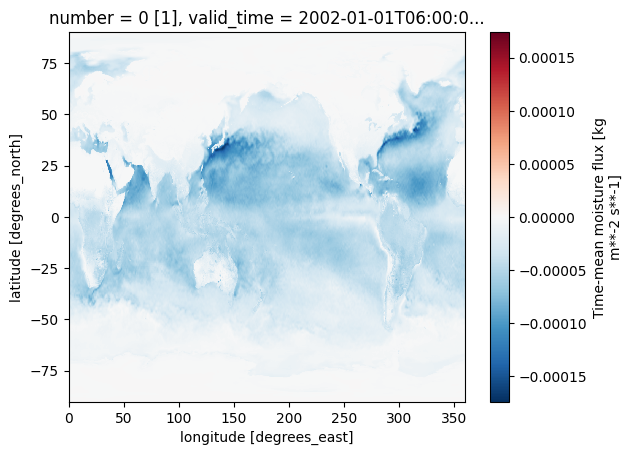

In [5]:
ds.avg_ie[0].plot()

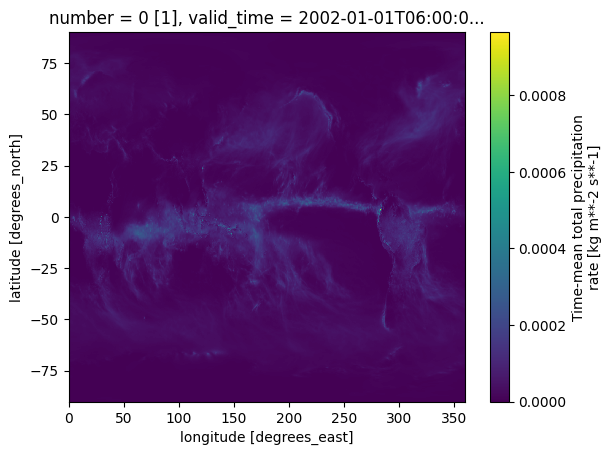

In [6]:
ds.avg_tprate[0].plot()

In [7]:
# from shxarray.geom.polygons import polygon2sh

In [31]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shxarray.core.logging import logger


def polygon2sh(polygeom,nmax:int=100,auxcoord=None,engine="shlib",**kwargs) ->xr.DataArray:
    
    if type(polygeom) != gpd.GeoSeries:
        polygeom=gpd.GeoSeries(polygeom)
    
    #create a dense enough grid encompassing all polgyons to use for spherical harmonic synthesis
    # heuristic way to figure out the resolution based on nmax
    dslonlat=xr.Dataset.sh.lonlat_grid(nmax,engine=engine)

    dims=["lon","lat"]
    coords={"lon":dslonlat.lon,"lat":dslonlat.lat}
    
    if auxcoord is None:
        coords["id"]=np.arange(len(polygeom))
        dims.append("id")
    else:
        if type(auxcoord) == pd.Series:
            dimk=auxcoord.name
            coords[dimk]=auxcoord.values
        else:
            # should be a dictionary like object
            if len(auxcoord) != 1:
                raise RuntimeError("Only one input coordinate is accepted")
            dimk=next(iter(auxcoord))
            coords[dimk]=auxcoord[dimk]
            
        dims.append(dimk)


    dtmp=xr.DataArray(np.zeros([dslonlat.sizes['lon'],dslonlat.sizes['lat'],len(polygeom)]),coords=coords,dims=dims).stack(lonlat=("lon","lat"))

    #create a geoDataframe of points from the grid
    ggrd=gpd.GeoDataFrame(geometry=[Point(lon,lat) for lon,lat in dtmp.lonlat.values],crs=4326)
    
    if polygeom.crs != ggrd.crs:
        #possibly convert the lon/lat grid in the desired projection before doing the polygon test
        ggrd=ggrd.to_crs(polygeom.crs)
    

    #query using a spatial index and set values to 1
    logger.info("Masking and gridding polygons")
    for i,poly in enumerate(polygeom): 
        idx=ggrd.sindex.query(poly,predicate="contains")
        dtmp[i,idx]=1.0
    

    dtmp=dtmp.unstack("lonlat")
    #logger.info("Applying SH analysis")
    #dsout=dtmp.sh.analysis(nmax,engine=engine) 

    return dtmp

In [32]:
import xarray as xr
from shxarray.core.sh_indexing import SHindexBase
from shxarray.core.shxarbase import ShXrBase
#from shxarray.geom.polygons import polygon2sh
from shxarray.geom.points import point2sh

import numpy as np

def from_geoseries(gseries,nmax:int,auxcoord=None,engine="shlib",**kwargs):
        
        gtypes=gseries.geom_type.unique()
        if len(gtypes) > 1:
            raise RuntimeError("from_gseries does not currently accept mixed geometry types")
        if gtypes[0] == "Polygon" or gtypes[0] == "MultiPolygon":
            return polygon2sh(gseries,nmax=nmax,auxcoord=auxcoord,engine=engine,kwargs=kwargs)

        elif gtypes[0] =="Point":
            return point2sh(gseries,nmax=nmax,auxcoord=auxcoord,**kwargs)
        else:
            raise RuntimeError(f"geometry type {gtypes[0]}, is not supported")

        # import pdb;pdb.set_trace() 
        # pass

In [33]:
shxengine='shtns' #requires shtns backend but is much quicker
nmax=300
dbasins_sh=from_geoseries(gdfbasins.geometry,nmax,auxcoord=gdfbasins.name,engine=shxengine)
dbasins_sh.name='basins'
display(dbasins_sh)

shxarray-INFO: Masking and gridding polygons


<xarray.DataArray 'basins' (name: 124, lon: 630, lat: 304)> Size: 190MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 5kB 0.0 0.5714 1.143 1.714 ... 358.3 358.9 359.4
  * lat      (lat) float64 2kB 89.55 88.96 88.37 87.78 ... -88.37 -88.96 -89.55
  * name     (name) object 992B 'SETIT' ... 'TIBETAN PLATEAU'

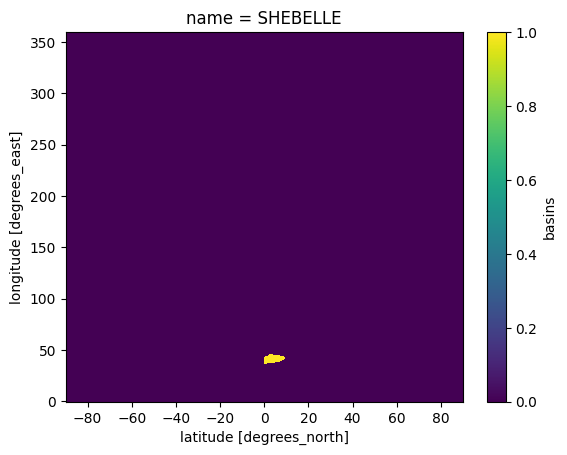

In [34]:
dbasins_sh.sel(name="SHEBELLE").plot()

Text(0.5, 1.0, 'SHEBELLE')

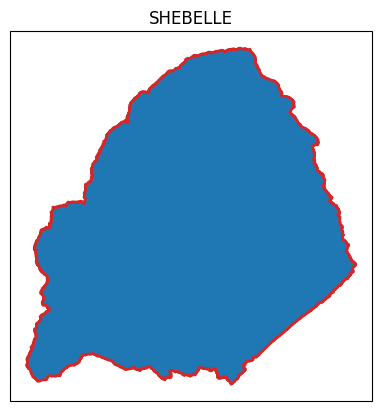

In [35]:
#quick visual check

basin='SHEBELLE'
gdfbasin=gdfbasins.loc[gdfbasins.name==basin]
lonmin,latmin,lonmax,latmax=gdfbasin.geometry.bounds.iloc[0]
res=0.125
margin=10*res
#dbasin_grd=dbasins_sh.sel(name=basin).sh.synthesis(lon=np.arange(lonmin-margin,lonmax+margin,res),lat=np.arange(latmin-margin,latmax+margin,res))
ax = plt.axes(projection=ccrs.PlateCarree())
gdfbasin.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(gdfbasin.geometry,edgecolor='tab:red',crs=ccrs.PlateCarree(),facecolor="none",lw=2)
ax.set_title(basin)